In [3]:
from keras.applications import xception
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import scipy.misc
from PIL import Image
import requests
from io import BytesIO
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage import data, exposure

%matplotlib inline

model = xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

91709440/91884032 [============================>.] - ETA: 0s

In [4]:
carina_orig = np.load('/Users/crjones/Box/Science/HargisDDRF/carina_224.npy')

In [5]:
carina_orig.shape

(224, 224, 3, 2240)

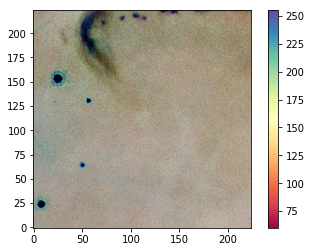

In [6]:
plt.imshow(carina_orig[:,:,:,100])
plt.colorbar()
plt.show()

In [7]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = np.round((gray - gray.min()) / (gray.max() - gray.min() ) * 255)

    blah = np.zeros((rgb.shape[0], rgb.shape[1], 3))
    blah[:,:,0], blah[:,:,1], blah[:,:,2] = gray, gray, gray
    
    return blah

carina = np.zeros(carina_orig.shape)

processing = 0
if processing == 1:
    for ii in range(carina_orig.shape[3]):
        carina[:,:,:,ii] = exposure.equalize_hist(carina_orig[:,:,:,ii])
elif processing == 2:
    for ii in range(carina.shape[3]):
        carina[:,:,:,ii] = rgb2gray(carina_orig[:,:,:,ii])
else:
    carina = carina_orig

/Users/crjones/Box Sync/Science/HargisDDRF/envs/keras35/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


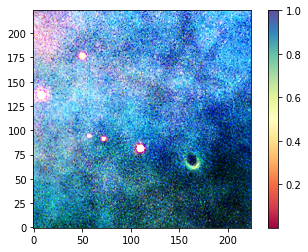

In [8]:
plt.imshow(carina[:,:,:,20])
plt.colorbar()
plt.show()

In [9]:
x = carina[0:224,0:224,:,1]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(x.shape)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
predictions = decode_predictions(preds, top=50)[0]
print('\nPredicted:')
for x in predictions:
    print(x)

(1, 224, 224, 3)

Predicted:
('n12267677', 'acorn', 0.96473533)
('n03485794', 'handkerchief', 0.013107417)
('n03160309', 'dam', 0.011722775)
('n04548362', 'wallet', 0.0058127879)
('n04613696', 'yurt', 0.0035972013)
('n02027492', 'red-backed_sandpiper', 0.00044841535)
('n03347037', 'fire_screen', 0.00030119196)
('n02916936', 'bulletproof_vest', 0.00020796212)
('n02834397', 'bib', 1.4250651e-05)
('n02091134', 'whippet', 1.3302285e-05)
('n04201297', 'shoji', 1.0992156e-05)
('n02999410', 'chain', 1.0831237e-05)
('n02783161', 'ballpoint', 9.6070416e-06)
('n03240683', 'drilling_platform', 5.6892923e-06)
('n02443484', 'black-footed_ferret', 4.5596468e-07)
('n02325366', 'wood_rabbit', 4.3553288e-07)
('n07717556', 'butternut_squash', 3.1651291e-07)
('n01855032', 'red-breasted_merganser', 2.5310194e-07)
('n02105056', 'groenendael', 2.1717526e-07)
('n04589890', 'window_screen', 1.5096927e-07)
('n03220513', 'dome', 1.4181438e-07)
('n03983396', 'pop_bottle', 7.5015976e-08)
('n03706229', 'magnetic_c

In [10]:
labels = []
allpredictions = {}
N = carina.shape[3]

for ii in range(N):
    x = carina[0:224,0:224,:,ii]
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    predictions = decode_predictions(preds, top=50)[0]
    
    allpredictions[ii] = []
    for tt in predictions:         
        allpredictions[ii].append([tt[1], tt[2]])

# Add in the rotated version
for ii in range(N):
    x = np.rot90(carina[0:224,0:224,:,ii], k=1)
    x = np.expand_dims(x, axis=0)
    y = preprocess_input(x)

    preds = model.predict(y)
    predictions = decode_predictions(preds, top=50)[0]    
    allpredictions[N+ii] = []
    for tt in predictions:         
        allpredictions[N+ii].append([tt[1], tt[2]])

# Add in the rotated x 2 versions
for ii in range(N):
    x = np.rot90(carina[0:224,0:224,:,ii], k=2)
    x = np.expand_dims(x, axis=0)
    y = preprocess_input(x)
    preds = model.predict(y)
    predictions = decode_predictions(preds, top=50)[0]    
    allpredictions[2*N+ii] = []
    for tt in predictions:         
        allpredictions[2*N+ii].append([tt[1], tt[2]])

# Add in the rotated x 3 versions
for ii in range(N):
    x = np.rot90(carina[0:224,0:224,:,ii], k=3)
    x = np.expand_dims(x, axis=0)
    y = preprocess_input(x)
    preds = model.predict(y)
    predictions = decode_predictions(preds, top=50)[0]    
    allpredictions[3*N+ii] = []
    for tt in predictions:         
        allpredictions[3*N+ii].append([tt[1], tt[2]])




Number of unqiue labels 87


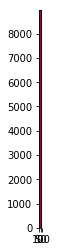

In [11]:
# Reformat the all information
labels = list(set([x[0] for k, y in allpredictions.items() for x in y ]))
X = np.zeros((len(allpredictions), len(labels)))
for ii in range(len(allpredictions)):
    for jj in allpredictions[ii]:
        X[ii,labels.index(jj[0])] = jj[1]
plt.imshow(X)
print('Number of unqiue labels {}'.format(len(labels)))


In [12]:
Y = TSNE(n_components=2).fit_transform(X)
#Y = PCA(n_components=2).fit_transform(X)

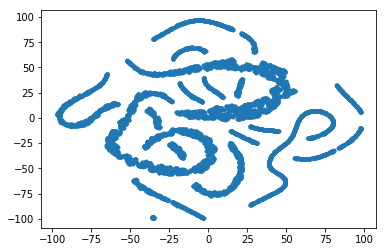

In [13]:
plt.plot(Y[:,0], Y[:,1], '.')

In [14]:
Y.shape

(8960, 2)

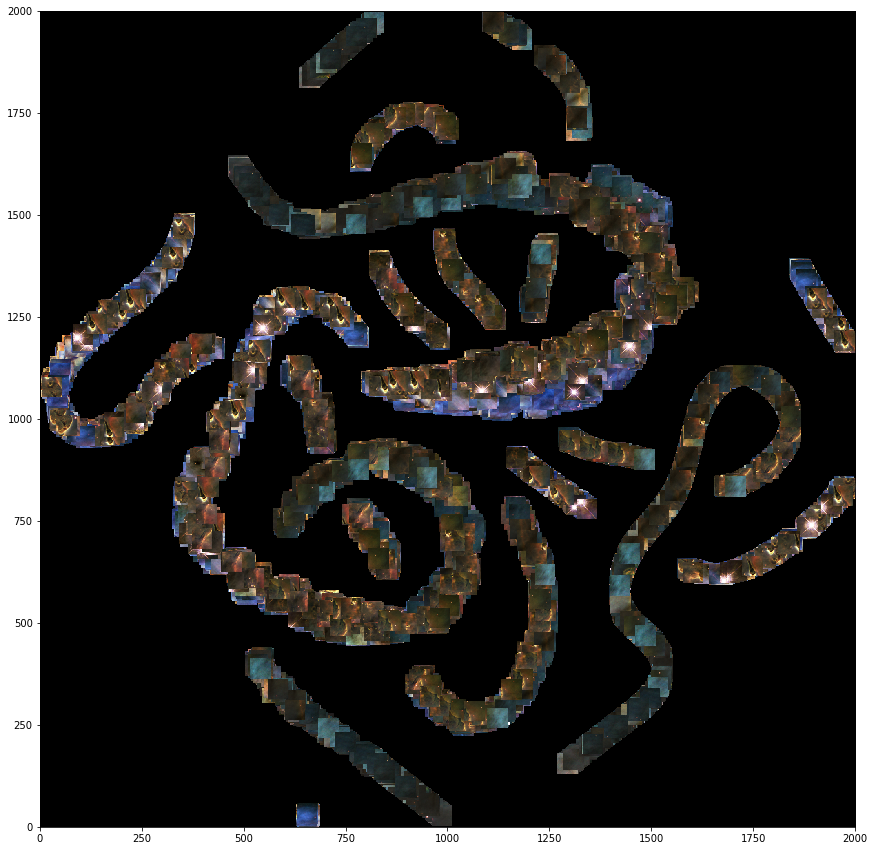

In [15]:
# set min point to 0 and scale
Y_min = np.min(Y, axis=0)
Y_max = np.max(Y, axis=0)

# create embedding image
S = 2000  # size of full embedding image
G = np.zeros((S, S, 3), dtype=np.uint8)
s = 50  # size of single image


for ii in range(Y.shape[0]):

    # set location
    x,y = Y[ii]
    
    a = (x - Y_min[0]) / (Y_max[0] - Y_min[0]) * S
    b = (y - Y_min[1]) / (Y_max[1] - Y_min[1]) * S
    a,b = int(a), int(b)
    
    I = scipy.misc.imresize(carina_orig[:,:,:,ii%N], (s, s, 3))
    
    if a>0 and b >0 and a+s < 2000 and b+s < 2000:
        G[b:b+s, a:a+s,:] = I

plt.figure(figsize=(15,15))
plt.imshow(G)
plt.show()

In [16]:
np.save('/Users/crjones/Box/Science/HargisDDRF/Carina/carina_histeq_rotations_InceptionResNetV2.npy', np.reshape(Y, [4, 2240, 2]))